In [2]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
import pymorphy2
import bisect
from collections import namedtuple,defaultdict
from tqdm import tqdm
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
#nltk.download('wordnet') 
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer


In [4]:
df = pd.read_csv('Fake news.csv', header = None)
df.drop([0,4,5,6,9], axis=1, inplace=True)
names = ['Header', 'Content', 'Time', 'Link', 'Label', 'Topic']
df.columns = names
df.head(4)

,Header,Content,Time,Link,Label,Topic
0,"В одном из ресторанов Нью-Йорка появится ""пяти...",Нью-йоркский ресторан Lucy's Cantina Royale бу...,6/10/2017,https://tass.ru/obschestvo/4625856,fake,Политика
1,Экс-глава МИ-6 рассказал о провальном плане за...,Бывший глава британской разведки МИ-6 Джон Ска...,15/08/2017,http://ren.tv/novosti/2017-08-15/eks-glava-mi-...,fake,Политика
2,Умерла нобелевский лауреат по литературе Светл...,Нобелевский лауреат по литературе Светлана Але...,18/05/2017,https://lenta.ru/news/2017/05/18/alex_nob/,fake,Знаменитости
3,"Путин превзошел Обаму на ГА ООН, думают 96% уч...","Большинство участников опроса, размещенного на...",0/10/2015,https://ria.ru/world/20151002/1295551989.html,fake,Политика


In [5]:
data = df
data = pd.DataFrame(data.fillna(""))
#data.columns = ["news"]
data["keywords"] = ""
data.head(4)

,Header,Content,Time,Link,Label,Topic,keywords
0,"В одном из ресторанов Нью-Йорка появится ""пяти...",Нью-йоркский ресторан Lucy's Cantina Royale бу...,6/10/2017,https://tass.ru/obschestvo/4625856,fake,Политика,
1,Экс-глава МИ-6 рассказал о провальном плане за...,Бывший глава британской разведки МИ-6 Джон Ска...,15/08/2017,http://ren.tv/novosti/2017-08-15/eks-glava-mi-...,fake,Политика,
2,Умерла нобелевский лауреат по литературе Светл...,Нобелевский лауреат по литературе Светлана Але...,18/05/2017,https://lenta.ru/news/2017/05/18/alex_nob/,fake,Знаменитости,
3,"Путин превзошел Обаму на ГА ООН, думают 96% уч...","Большинство участников опроса, размещенного на...",0/10/2015,https://ria.ru/world/20151002/1295551989.html,fake,Политика,


## preprocessing labels

In [7]:
y = data['Label'].apply(lambda x:0 if (x=="Fake" or x == "fake" or x =="") else x)
y = y.apply(lambda x: 1 if(x=="Half-Fake") else x)
y = y.apply(lambda x: 2 if (x == "Truth") else x)
y = y.fillna(0)
data['Label'] = y

In [8]:
##Creating a list of stop words and adding custom stopwords
stop_words = set(stopwords.words('russian'))
new_words = ['что', 'это', 'так', 'вот','ещё', 'свой' , 'быть','й', 'как', 'в', 'наш', 'к', 'на','свой', 
             'который', 'очень', 'которые','кстати', 'также', 'весь']
stop_words = stop_words.union(new_words)

In [9]:
def processing(texts):
    corpus = []
    for i in range(0, len(texts)):
        #Remove punctuations
        text = re.sub(r'\W', ' ', texts['Content'][i])
        #print(text)
        #Convert to lowercase
        text = text.lower()

        #remove tags
        text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)

        # remove special characters and digits
        text=re.sub("(\\d|\\W)+"," ",text)

        ##Convert to list from string
        text = text.split()

        ## pymorphy
        analyzer = pymorphy2.MorphAnalyzer()  
        text = (analyzer.normal_forms(word)[0] for word in text)

        ##Stemming
        ps=PorterStemmer()
        #Lemmatisation
        lem = WordNetLemmatizer()
        text = [lem.lemmatize(word) for word in text if not word in  
                stop_words] 
        text = " ".join(text)
        corpus.append(text)
    return corpus
corpus = processing(data)
corpus[2]

'нобелевский лауреат литература светлана алексий скончаться метр год жизнь сообщить министр культура франция франсуаза ниссный twitter белорусский писательница получить нобелевский премия год формулировка многоголосый звучание проза увековечивание страдание мужество алексий приобрести известность публикация художественно документальный книга война женский лицо перу принадлежать произведение цинковый мальчик чернобыльский молитва время секонда хэнд литератор активно участвовать общественный жизнь принадлежать спорный политический высказывание пример июнь год нью йорк сказать год война худой еврей относиться поляк алексий ссылаться знакомый журналист польша заявить местный ксёндз время проповедь призывать убивать еврей мид польша резко раскритиковать писательница слово'

In [10]:
corpus[10]

'минобороны россия качество доказательство сотрудничество сша иго опубликовать скриншот мобильный игра ac gunship simulator special ops squadron'

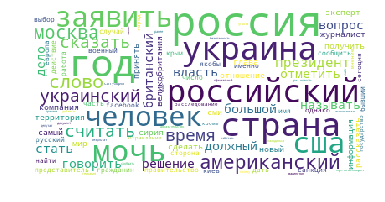

In [11]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop_words,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(corpus))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=900)

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer(max_df=0.8,stop_words=stop_words, max_features=10000, ngram_range=(1,3))
X=cv.fit_transform(corpus)

## uni - gramms

[Text(0, 0, 'россия'),
 Text(0, 0, 'год'),
 Text(0, 0, 'российский'),
 Text(0, 0, 'украина'),
 Text(0, 0, 'страна'),
 Text(0, 0, 'человек'),
 Text(0, 0, 'сша'),
 Text(0, 0, 'мочь'),
 Text(0, 0, 'заявить'),
 Text(0, 0, 'президент'),
 Text(0, 0, 'американский'),
 Text(0, 0, 'дело'),
 Text(0, 0, 'украинский'),
 Text(0, 0, 'время'),
 Text(0, 0, 'слово')]

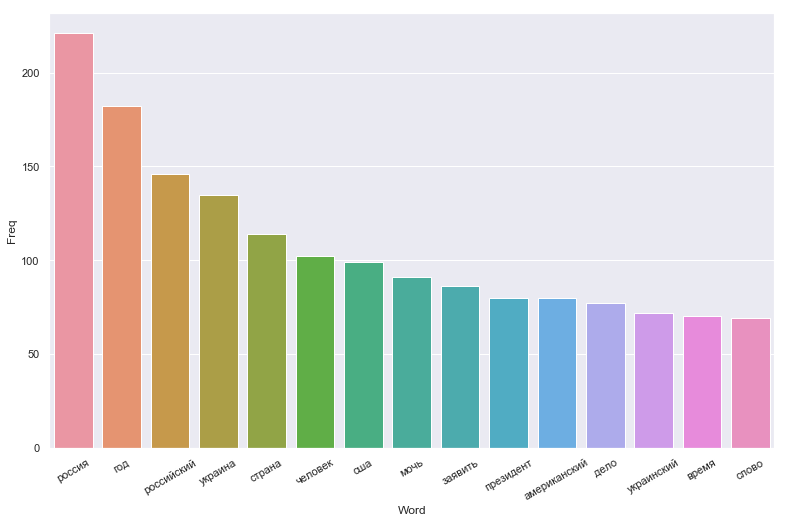

In [13]:
#Most frequently occuring words
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in      
                   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                       reverse=True)
    return words_freq[:n]
#Convert most freq words to dataframe for plotting bar plot
top_words = get_top_n_words(corpus, n=15)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
#Barplot of most freq words
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(x="Word", y="Freq", data=top_df)
g.set_xticklabels(g.get_xticklabels(), rotation=30)


## Bi - gramms

[Text(0, 0, 'риа новость'),
 Text(0, 0, 'владимир путин'),
 Text(0, 0, 'соединить штат'),
 Text(0, 0, 'православный церковь'),
 Text(0, 0, 'отравлять вещество'),
 Text(0, 0, 'социальный сеть'),
 Text(0, 0, 'химический оружие'),
 Text(0, 0, 'вооружённый сила'),
 Text(0, 0, 'год назад'),
 Text(0, 0, 'юлия скрипаль'),
 Text(0, 0, 'нервно паралитический'),
 Text(0, 0, 'следственный группа'),
 Text(0, 0, 'президент россия'),
 Text(0, 0, 'последний время'),
 Text(0, 0, 'официальный представитель')]

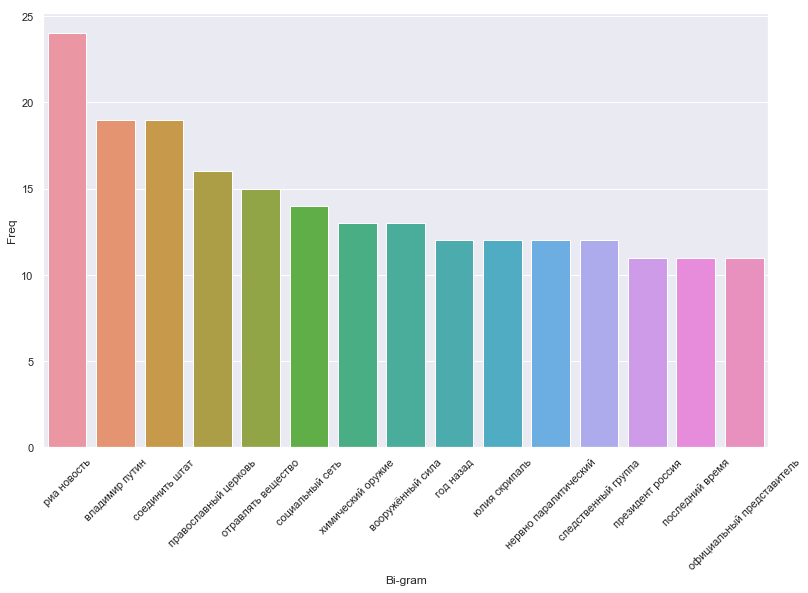

In [14]:
#Most frequently occuring Bi-grams
def get_top_n2_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(2,2),  
            max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]
top2_words = get_top_n2_words(corpus, n=15)
top2_df = pd.DataFrame(top2_words)
top2_df.columns=["Bi-gram", "Freq"]
#print(top2_df)
#Barplot of most freq Bi-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Bi-gram", y="Freq", data=top2_df)
h.set_xticklabels(h.get_xticklabels(), rotation=45)

## tri - gramms

[Text(0, 0, 'нервно паралитический вещество'),
 Text(0, 0, 'официальный представитель мид'),
 Text(0, 0, 'международный следственный группа'),
 Text(0, 0, 'доказательство российский присутствие'),
 Text(0, 0, 'украинский православный церковь'),
 Text(0, 0, 'паралитический вещество новичок'),
 Text(0, 0, 'министр иностранный дело'),
 Text(0, 0, 'ракета сбить аэродром'),
 Text(0, 0, 'президент россия владимир'),
 Text(0, 0, 'россия владимир путин'),
 Text(0, 0, 'московский антидопинговый лаборатория'),
 Text(0, 0, 'русский православный церковь'),
 Text(0, 0, 'ван дёр беллена'),
 Text(0, 0, 'лаборатория портон даун'),
 Text(0, 0, 'положение договор дружба')]

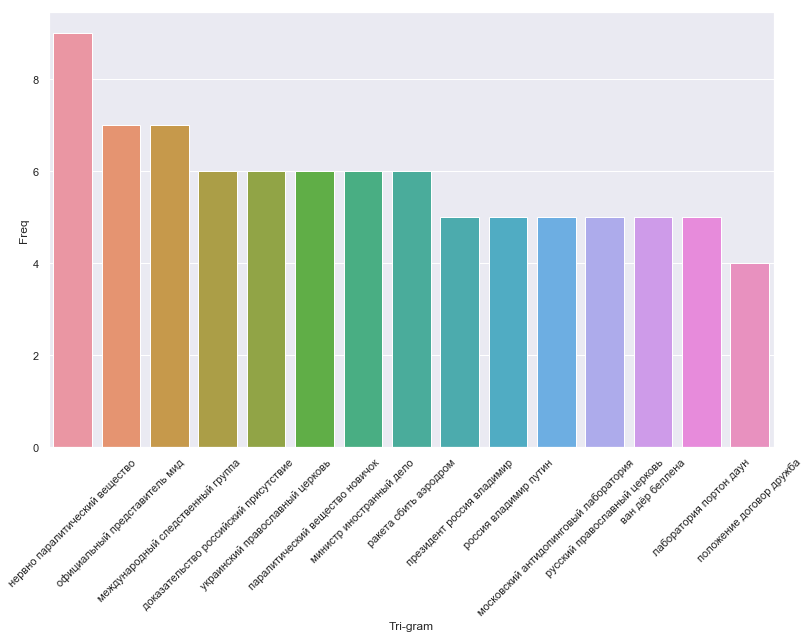

In [16]:
#Most frequently occuring Tri-gramms
def get_top_n3_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(3,3), 
           max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]
top3_words = get_top_n3_words(corpus, n=15)
top3_df = pd.DataFrame(top3_words)
top3_df.columns=["Tri-gram", "Freq"]
#print(top3_df)
#Barplot of most freq Tri-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
j=sns.barplot(x="Tri-gram", y="Freq", data=top3_df)
j.set_xticklabels(j.get_xticklabels(), rotation=45)

In [23]:
from scipy.sparse import coo_matrix
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results



### doc = 1, tf - idf

In [26]:
from sklearn.feature_extraction.text import TfidfTransformer
 
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(X)
# get feature names
feature_names=cv.get_feature_names()

doc_id = 1
# fetch document for which keywords needs to be extracted
doc=corpus[doc_id]
 
#generate tf-idf for the given document
tf_idf_vector=tfidf_transformer.transform(cv.transform([doc]))
#sort the tf-idf vectors by descending order of scores
sorted_items=sort_coo(tf_idf_vector.tocoo())
#extract only the top n; n here is 10
keywords=extract_topn_from_vector(feature_names,sorted_items,10)
 
# now print the results
print("\nAbstract:")
print(doc)
keywords_tf_idf = []
print("\nKeywords:")
for k in keywords:
    print(k,keywords[k])
    keywords_tf_idf.append(k)


Abstract:
бывший глава британский разведка ми джон скарлетта раскрыть деталь стратегический план якобы направить развал россия рассказать интервью издание the guardian впоследствии статья удалить сайт издание прежний доступный просмотр кэш самый проработать стратегический план сша великобритания развал россия последний несколько год закончиться неудача рассказать скарлетта слово скарлетта западный страна планировать развернуть военный разведывательный база территория южный осетия приход власть саакашвили дальнейший планироваться привлечь дестабилизация обстановка радикальный исламист сожаление война год грузия стать железный кулак москва против самый большой стратегический план кавказ поведать экс глава разведка кроме планироваться шаг организация база территория украина скарлетта рассказать представитель западный государство якобы рассчитывать фиктивный война россия украина отметить москва удаться успешно преодолеть расставить препятствие обезопасить страна воздействие великобритания

### doc = 1, term-freq

In [27]:
tf_transformer=TfidfTransformer(smooth_idf=True,use_idf=False)
tf_transformer.fit(X)
# get feature names
feature_names=cv.get_feature_names()
 
#generate tf-idf for the given document
tf_vector=tf_transformer.transform(cv.transform([doc]))

#sort the tf-idf vectors by descending order of scores
sorted_items=sort_coo(tf_vector.tocoo())
#extract only the top n; n here is 10
keywords=extract_topn_from_vector(feature_names,sorted_items,10)
print("\nAbstract:")
print(doc)
keywords_tf = []
print("\nKeywords:")
for k in keywords:
    print(k,keywords[k])
    keywords_tf.append(k)


Abstract:
бывший глава британский разведка ми джон скарлетта раскрыть деталь стратегический план якобы направить развал россия рассказать интервью издание the guardian впоследствии статья удалить сайт издание прежний доступный просмотр кэш самый проработать стратегический план сша великобритания развал россия последний несколько год закончиться неудача рассказать скарлетта слово скарлетта западный страна планировать развернуть военный разведывательный база территория южный осетия приход власть саакашвили дальнейший планироваться привлечь дестабилизация обстановка радикальный исламист сожаление война год грузия стать железный кулак москва против самый большой стратегический план кавказ поведать экс глава разведка кроме планироваться шаг организация база территория украина скарлетта рассказать представитель западный государство якобы рассчитывать фиктивный война россия украина отметить москва удаться успешно преодолеть расставить препятствие обезопасить страна воздействие великобритания

In [28]:
# список из частых и "ключевых"
keywords = list(set(keywords_tf_idf + keywords_tf))

In [31]:
data["keywords"][doc] = keywords
data["keywords"][doc]

['развал',
 'рассказать',
 'россия',
 'стратегический план',
 'стратегический',
 'якобы',
 'план',
 'база',
 'планироваться',
 'база территория',
 'скарлетта',
 'развал россия',
 'территория',
 'сша',
 'украина']

# Extract keywords from fakes

In [33]:
for i in range(len(data)):
    doc_id = i
    doc=corpus[doc_id]
    keywords_tf_idf = []
    keywords_tf = []
    
    #generate tf-idf for the given document
    tf_idf_vector=tfidf_transformer.transform(cv.transform([doc]))
    sorted_items=sort_coo(tf_idf_vector.tocoo())
    keywords=extract_topn_from_vector(feature_names,sorted_items,5)
    for k in keywords:
        keywords_tf_idf.append(k)
    
    #generate tf 
    tf_transformer=TfidfTransformer(smooth_idf=True,use_idf=False)
    tf_transformer.fit(X)
    feature_names=cv.get_feature_names()
    tf_vector=tf_transformer.transform(cv.transform([doc]))
    sorted_items=sort_coo(tf_vector.tocoo())
    keywords=extract_topn_from_vector(feature_names,sorted_items,10)
    for k in keywords:
        keywords_tf.append(k)
   
    keywords = list((set(keywords_tf_idf + keywords_tf)))
    keywords = ','.join(keywords)
    data["keywords"][doc_id] = keywords
    
    
    

In [34]:
data['keywords'][1:5]

1    развал,рассказать,россия,стратегический план,с...
2    время,еврей,принадлежать,нобелевский,алексий,г...
3    считать,газета,убедительный,президент,путин,вы...
4    погибнуть врач,скора помощь,ребёнок,помощь,ско...
Name: keywords, dtype: object

In [43]:
data.to_csv('fake news data.csv', sep='\t', encoding='utf-8')